# Multi-Objective Indicator Selection via Backtracking
====================================================

This notebook demonstrates how to combine multiple objectives:
1) Coverage (split as 'risk coverage' vs. 'consequence coverage'),
2) Easiness of measuring the indicator,
3) Impact on well-being (high vs. low),
4) Mitigation ease (lower means easier to mitigate, if desired),
and then systematically select the best subset of indicators
under the constraints:
- Budget (Total_Cost) ≤ BUDGET
- Time (Total_Time) ≤ DEADLINE
- Number of indicators ≤ MAX_INDICATORS

No external optimization library is used; we rely on a
custom backtracking approach.

NOTE:
-----
- Backtracking is exact but exponential $(O(2^N))$.
- For large N, consider branch-and-bound or time-limited search.
- The code is organized into sections for clarity.

In this new workbook we will creata a more detailed and formal model for optimising animal wellfare indicators



In [53]:
import pandas as pd
import time


In [54]:
# --------------------------------------------------------------------
#             2) Data Loading
# --------------------------------------------------------------------
# Adjust the CSV path as needed for your environment.
DATA_PATH = "../data/dairy_cows.csv"  # or wherever your data is located

df = pd.read_csv(DATA_PATH)
df.head()


,ID,Species,Animal_Class,WQ_Principles,WQ_Criteria,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Affective_States,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,Welfare_Indicator,Indicator_Type,Indicator_Dimensions,Indicator_Ease,Indicator_Resources,Hazards_Source_1,Hazards_Source_2,Global_Usage,Norway_Usage
0,1,Dairy cows,Tie stalls,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,Abdominal discomfort,Welfare outcome,Health/physical/production,Moderate,Low,7.0,NaN,F,Y
1,1,Dairy cows,Cubicles,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,Abdominal discomfort,Welfare outcome,Health/physical/production,Moderate,Low,7.0,NaN,F,Y
2,2,Dairy cows,Tie stalls,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,Agonistic behaviour,Welfare outcome,Behavioural,Moderate,Low,7.0,NaN,"F, R",Y
3,2,Dairy cows,Cubicles,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,Agonistic behaviour,Welfare outcome,Behavioural,Moderate,Low,7.0,NaN,"F, R",Y
4,3,Dairy cows,Tie stalls,Appropiate behaviour,Expression of other behaviours,Insufficient space,Restriction of movement,Discomfort,High,Moderate,Agonistic interactions,Welfare outcome,Behavioural,Moderate,Medium,NaN,13a,R,N (research only)


## 1. Data Preprocessing

- **Purpose:** Convert categorical data into a clean, numerical format suitable for analysis.
- **Steps:**
  1. **Identify** relevant categorical columns.
  2. **Clean** data by converting to strings and removing whitespace.
  3. **Map** categorical values to numerical scores using predefined dictionaries.
  4. **Create** new numerical columns based on these mappings.
  5. **Verify** the transformations with a data preview.

This preprocessing ensures that the dataset is standardized and ready for subsequent analysis.

In [55]:
# --------------------------------------------------------------------
#             3) Data Cleaning & Preparation
# --------------------------------------------------------------------
# Ensure that relevant columns are strings, stripped of whitespace, etc.
categorical_columns = [
    'Species',
    'Animal_Class',
    'Welfare_Hazards_Animal',
    'Welfare_Hazards_Consequences',
    'Welfare_Hazards_Impact',
    'Ease_of_Hazard_Mitigation',
    'Welfare_Indicator',
    'Indicator_Ease',
    'Indicator_Resources'
]

for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip()

# Mappings for numeric transformations
impact_mapping = {
    'Low': 1,
    'High': 2
}
ease_mapping = {
    'Easy': 1,
    'Moderate': 2,
    'Difficult': 3
}
resources_mapping = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}

df['Impact_Num'] = df['Welfare_Hazards_Impact'].map(impact_mapping)
df['Ease_Num'] = df['Indicator_Ease'].map(ease_mapping)
df['Resources_Num'] = df['Indicator_Resources'].map(resources_mapping)
df['Mitigation_Ease_Num'] = df['Ease_of_Hazard_Mitigation'].map(ease_mapping)

df.head()


,ID,Species,Animal_Class,WQ_Principles,WQ_Criteria,Welfare_Hazards_Animal,Welfare_Hazards_Consequences,Welfare_Hazards_Affective_States,Welfare_Hazards_Impact,Ease_of_Hazard_Mitigation,...,Indicator_Ease,Indicator_Resources,Hazards_Source_1,Hazards_Source_2,Global_Usage,Norway_Usage,Impact_Num,Ease_Num,Resources_Num,Mitigation_Ease_Num
0,1,Dairy cows,Tie stalls,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,...,Moderate,Low,7.0,NaN,F,Y,2,2,1,2
1,1,Dairy cows,Cubicles,Good Health,Absence of disease,Pasture access,Gastro-enteric disorders,Discomfort,High,Moderate,...,Moderate,Low,7.0,NaN,F,Y,2,2,1,2
2,2,Dairy cows,Tie stalls,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,...,Moderate,Low,7.0,NaN,"F, R",Y,1,2,1,3
3,2,Dairy cows,Cubicles,Appropiate behaviour,Expression of social behaviours,Continuous housing for long periods,General disruption of behaviour,Di(stress),Low,Difficult,...,Moderate,Low,7.0,NaN,"F, R",Y,1,2,1,3
4,3,Dairy cows,Tie stalls,Appropiate behaviour,Expression of other behaviours,Insufficient space,Restriction of movement,Discomfort,High,Moderate,...,Moderate,Medium,NaN,13a,R,N (research only),2,2,2,2


## 2. Defining the Multi-Objective Formula

We want to consider:

1. **Coverage**:  
   - Split into **risks** and **consequences** coverage. Let each indicator $i$ have:
     - ${riskCoverage}_i$ = number of unique hazards (risks) that indicator covers  
     - ${consequenceCoverage}_i$ = number of unique consequences that indicator covers  
   - We want a **weighted** sum of the two, e.g.  
     $$
       {coverage}_i = \alpha \times {riskCoverage}_i \;+\; \beta \times {consequenceCoverage}_i
     $$
   - Then we also might apply a global weight $ w_{cover} $ to coverage.

2. **Easiness**:  
   - If `Ease_Num` is **1 = easy**, **2 = moderate**, **3 = difficult** to measure, we want to **give higher objective for smaller `Ease_Num`**.  
   - One way is: ${easinessScore}_i = 4 - {Ease\_Num}_i$, so that 1 => 3 points, 2 => 2 points, 3 => 1 point. Or simply we do a negative factor of `Ease_Num`.  
   - Example: ${easiness}_i = -( {Ease\_Num}_i )$ so that “easy to measure” (Ease_Num=1) yields a higher final objective than “difficult” (Ease_Num=3).  
   - Then multiply by a weight $ w_{ease} $.

3. **Impact**:  
   - If `Impact_Score` is higher for more impactful indicators (e.g. 2 = High, 1 = Low), we can directly add it to the objective. Multiply by $ w_{impact} $.

4. **Mitigation Ease**:  
   - We suppose that we want to “**minimize mitigation ease** (are easy to mitigate).” 
   - Interpreting that: We want to prefer hazards that are **easier** to mitigate, i.e. a smaller `Mitigation_Ease_Num` (assuming 1=Easy, 3=Difficult). If so, that’s something we want to *maximize* in the objective. But `Mitigation_Ease_Num` itself is bigger for “difficult.”  
   - One approach: define ${mitigationScore}_i = 4 - {Mitigation\_Ease\_Num}_i$. So if 1=easy, that yields `3`; if 3=difficult, that yields `1`. Then multiply by $-1$ if we actually want to *minimize* that dimension.  
   - Alternatively, if we literally want “the lower the `Mitigation_Ease_Num`, the better,” we can define ${mitigationScore}_i = -( {Mitigation\_Ease\_Num}_i )$. So a smaller number yields a bigger final objective.  
   - Multiply by a weight $ w_{miti} $.  

Putting it all together, we will get a **combined objective** per indicator $ i $:

$$
  {objective}_i \;=\; 
  w_{cover}\,\bigl(\alpha\,{riskCoverage}_i + \beta\,{consequenceCoverage}_i\bigr)\;+\;
  w_{ease}\,\bigl({easinessScore}_i\bigr)\;+\;
  w_{impact}\,\bigl({Impact_Score}_i\bigr)\;+\;
  w_{miti}\,\bigl({mitigationScore}_i\bigr)
$$

When selecting a **subset** $ S \subseteq \{1,\dots,N\}$, our total objective is:

$$
  {Objective}(S) \;=\;\sum_{i \,\in\, S}\;{objective}_i
$$


In [56]:
# --------------------------------------------------------------------
#             4) Aggregation: Distinguish Risk vs. Consequence Coverage
# --------------------------------------------------------------------
# We want to separate coverage into:
#  - 'n_risks' for unique hazards (Welfare_Hazards_Animal)
#  - 'n_cons'  for unique consequences (Welfare_Hazards_Consequences)
#
# Then we'll merge those with other numeric columns (Ease_Num, Impact_Num, etc.).

df_coverage = (
    df.groupby('Welfare_Indicator', as_index=False)
    .agg(
        n_risks=('Welfare_Hazards_Animal', 'nunique'),
        n_cons=('Welfare_Hazards_Consequences', 'nunique')
    )
)

# Now let's combine with numeric columns from the original df.
# But first let's pick one row per Welfare_Indicator for ease, 
# or average them if multiple rows differ. 
# If they're truly duplicates (same indicator, same numeric data), 
# then drop_duplicates(subset=['Welfare_Indicator']) would suffice.

# We'll use a groupby approach for the numeric columns:
df_numeric = (
    df.groupby('Welfare_Indicator', as_index=False)
    .agg(
        Ease_Num=('Ease_Num', 'mean'),
        Impact_Num=('Impact_Num', 'mean'),
        Mitigation_Ease_Num=('Mitigation_Ease_Num', 'mean'),
        # For cost/time, we might handle them separately. 
        # We'll do that below using a different approach if needed.
    )
)

# We'll also define cost/time from an approach similar to your earlier logic:
# (You can adjust coefficients as you like)
coeff_cost_ease = 50
coeff_cost_resources = 25
coeff_time_ease = 2
coeff_time_resources = 1

# We'll assume we want the max "Resources_Num" found among duplicates 
# or something similar, but let's do an average for demonstration:
df_cost = (
    df.groupby('Welfare_Indicator', as_index=False)
    .agg(
        Ease_Num=('Ease_Num', 'mean'),
        Resources_Num=('Resources_Num', 'mean')
    )
)

# We'll compute cost/time using the average of Ease/Resources for each indicator.
df_cost['Total_Cost'] = (
    coeff_cost_ease * df_cost['Ease_Num']
    + coeff_cost_resources * df_cost['Resources_Num']
)
df_cost['Total_Time'] = (
    coeff_time_ease * df_cost['Ease_Num']
    + coeff_time_resources * df_cost['Resources_Num']
)

# We'll keep only relevant columns
df_cost = df_cost[['Welfare_Indicator', 'Total_Cost', 'Total_Time']]

# Merge coverage with the numeric columns
df_agg = pd.merge(df_coverage, df_numeric, on='Welfare_Indicator', how='left')

# Then merge with cost/time
df_agg = pd.merge(df_agg, df_cost, on='Welfare_Indicator', how='left')

df_agg.head()


,Welfare_Indicator,n_risks,n_cons,Ease_Num,Impact_Num,Mitigation_Ease_Num,Total_Cost,Total_Time
0,Abdominal discomfort,1,1,2.0,2.0,2.0,125.0,5.0
1,Agonistic behaviour,1,1,2.0,1.0,3.0,125.0,5.0
2,Agonistic interactions,1,1,2.0,2.0,2.0,150.0,6.0
3,Allo-grooming,1,1,2.0,1.0,3.0,150.0,6.0
4,Altered resting posture,1,1,2.0,2.0,3.0,125.0,5.0


In [57]:
# --------------------------------------------------------------------
#             5) Define Our Multi-Objective Score
# --------------------------------------------------------------------
# The user wants:
# 1) Max coverage (split as alpha*riskCoverage + beta*consequenceCoverage)
# 2) Max easiness (lower Ease_Num is better => we transform it so "lower => higher" in objective)
# 3) Max impact (Impact_Num, bigger is better)
# 4) Minimize mitigation ease (lower Mitigation_Ease_Num is better => transform similarly)
#
# Then sum these with user-defined weights.

# Let's define some global weights:
w_cover = 1.0     # weight for coverage
w_ease  = 1.0     # weight for easiness
w_impact= 1.0     # weight for impact
w_miti  = 1.0     # weight for mitigation preference

# Coverage sub-weights
alpha = 1.0  # hazards
beta  = 1.0  # consequences

def compute_objective(row):
    """
    row: a row from df_agg containing:
      - n_risks, n_cons
      - Ease_Num, Impact_Num, Mitigation_Ease_Num
      - Total_Cost, Total_Time (not used in objective directly, but used in constraints)
    """
    # coverage = alpha * n_risks + beta * n_cons
    coverage_i = alpha * row['n_risks'] + beta * row['n_cons']
    
    # transform Ease_Num => bigger is better (3 for 'Easy'=1 => 3 - 1 => 2, or 4 - Ease_Num)
    # For example:
    ease_i = 4 - row['Ease_Num']  # if 1 => 3, if 2 => 2, if 3 => 1
    
    # Impact_Num is already bigger=better (1=Low, 2=High). 
    impact_i = row['Impact_Num']
    
    # Mitigation_Ease_Num => also smaller is better. So we do (4 - Mitigation_Ease_Num).
    # If Mitigation_Ease_Num=1 => 3; if=3 => 1
    miti_i = 4 - row['Mitigation_Ease_Num']
    
    # Weighted sum
    multi_obj = (
        w_cover  * coverage_i
        + w_ease   * ease_i
        + w_impact * impact_i
        + w_miti   * miti_i
    )
    return multi_obj

df_agg['Multi_Objective'] = df_agg.apply(compute_objective, axis=1)

df_agg.head(10)


,Welfare_Indicator,n_risks,n_cons,Ease_Num,Impact_Num,Mitigation_Ease_Num,Total_Cost,Total_Time,Multi_Objective
0,Abdominal discomfort,1,1,2.0,2.0,2.000000,125.0,5.0,8.000000
1,Agonistic behaviour,1,1,2.0,1.0,3.000000,125.0,5.0,6.000000
2,Agonistic interactions,1,1,2.0,2.0,2.000000,150.0,6.0,8.000000
3,Allo-grooming,1,1,2.0,1.0,3.000000,150.0,6.0,6.000000
4,Altered resting posture,1,1,2.0,2.0,3.000000,125.0,5.0,7.000000
5,Amount of eye white,2,1,2.0,2.0,2.000000,150.0,6.0,9.000000
6,Body condition scoring,4,1,2.0,2.0,1.500000,125.0,5.0,11.500000
7,Brush use,1,1,2.0,1.0,3.000000,150.0,6.0,6.000000
8,Calving behaviour (difficult/long calving),1,1,2.0,2.0,2.000000,125.0,5.0,8.000000
9,Calving records (death of cow),3,1,1.0,2.0,1.333333,75.0,3.0,11.666667


## Simple greedy option

In [71]:
def select_best_indicators_greedy(df_agg, budget, deadline, max_indic, heuristic='score_per_cost'):
    """
    Greedy selection function to choose the best subset of indicators based on a heuristic.
    
    Parameters:
    - df_agg (DataFrame): Aggregated DataFrame with indicators and scores.
    - budget (float): Total budget constraint.
    - deadline (float): Total time constraint.
    - max_indic (int): Maximum number of indicators to select.
    - heuristic (str): Heuristic to prioritize indicators. Options:
        - 'score_per_cost': Objective score divided by cost.
        - 'score_per_time': Objective score divided by time.
        - 'combined': (Objective score) / (cost + time).
    
    Returns:
    - results_df (DataFrame): DataFrame of selected indicators with coverage details.
    - total_obj (float): Total objective score of the selection.
    - total_cost (float): Total cost of the selection.
    - total_time (float): Total time of the selection.
    - total_risks (int): Total number of unique risks covered.
    - total_cons (int): Total number of unique consequences covered.
    - execution_time (float): Total execution time in seconds.
    """
    import time
    
    # Start timing
    start_time = time.time()
    
    # Define the heuristic scores
    if heuristic == 'score_per_cost':
        df_agg['Heuristic_Score'] = df_agg['Multi_Objective'] / df_agg['Total_Cost']
    elif heuristic == 'score_per_time':
        df_agg['Heuristic_Score'] = df_agg['Multi_Objective'] / df_agg['Total_Time']
    elif heuristic == 'combined':
        df_agg['Heuristic_Score'] = df_agg['Multi_Objective'] / (df_agg['Total_Cost'] + df_agg['Total_Time'])
    else:
        raise ValueError("Invalid heuristic. Choose from 'score_per_cost', 'score_per_time', or 'combined'.")
    
    # Sort indicators based on heuristic score in descending order
    sorted_df = df_agg.sort_values(by='Heuristic_Score', ascending=False).reset_index(drop=True)
    
    # Initialize selection variables
    selected_indicators = []
    total_obj = 0.0
    total_cost = 0.0
    total_time = 0.0
    total_risks = 0
    total_cons = 0
    
    # Iterate through the sorted indicators and select them if constraints allow
    for _, row in sorted_df.iterrows():
        if (total_cost + row['Total_Cost'] <= budget and
            total_time + row['Total_Time'] <= deadline and
            len(selected_indicators) < max_indic):
            
            selected_indicators.append(row['Welfare_Indicator'])
            total_obj += row['Multi_Objective']
            total_cost += row['Total_Cost']
            total_time += row['Total_Time']
            total_risks += row['n_risks']
            total_cons += row['n_cons']
    
    # Create the results DataFrame
    results_df = df_agg[df_agg['Welfare_Indicator'].isin(selected_indicators)].copy()
    results_df = results_df[['Welfare_Indicator', 'Multi_Objective', 'n_risks', 'n_cons', 'Total_Cost', 'Total_Time']]
    results_df = results_df.rename(columns={'Multi_Objective': 'Objective_Score'})
    
    # Record end time
    end_time = time.time()
    execution_time = end_time - start_time
    
    return results_df, total_obj, total_cost, total_time, total_risks, total_cons, execution_time


In [72]:
# Define your constraints
BUDGET = 1200      # Total budget in dollars
DEADLINE = 100      # Total time in days
MAX_INDICATORS = 6 # Maximum number of indicators to select
HEURISTIC = 'score_per_cost'  # Choose from 'score_per_cost', 'score_per_time', 'combined'

# Run the greedy selection
selected_df_greedy, best_score_greedy, used_cost_greedy, used_time_greedy, total_risks_greedy, total_cons_greedy, execution_time_greedy = select_best_indicators_greedy(
    df_agg,
    BUDGET,
    DEADLINE,
    MAX_INDICATORS,
    heuristic=HEURISTIC
)

# Display the selected indicators
print("Selected Indicators (Greedy):")
display(selected_df_greedy)

# Print summary information
print(f"Best Score Found: {best_score_greedy:.2f}")
print(f"Total Cost: ${used_cost_greedy:.2f} (Budget = ${BUDGET})")
print(f"Total Time: {used_time_greedy:.2f} days (Deadline = {DEADLINE})")
print(f"Total Risks Covered: {total_risks_greedy}")
print(f"Total Consequences Covered: {total_cons_greedy}")
print(f"Execution Time: {execution_time_greedy:.4f} seconds")

Selected Indicators (Greedy):


,Welfare_Indicator,Objective_Score,n_risks,n_cons,Total_Cost,Total_Time
9,Calving records (death of cow),11.666667,3,1,75.0,3.0
13,Cow Pain Scale (attention towards surroundings...,25.285714,14,6,150.0,6.0
21,"Hot, red, painful udder",12.400000,5,1,75.0,3.0
27,Injuries,16.500000,8,2,75.0,3.0
29,Lesions of the claw,10.500000,2,2,75.0,3.0
36,Physiological stress indicators,39.900000,28,8,225.0,9.0


Best Score Found: 116.25
Total Cost: $675.00 (Budget = $1200)
Total Time: 27.00 days (Deadline = 100)
Total Risks Covered: 60
Total Consequences Covered: 20
Execution Time: 0.0117 seconds


In [73]:
def backtracking_select(
    items, idx,
    budget_left, time_left,
    max_indic_left,
    current_score, current_subset,
    best_solution,
    start_time=None,
    time_limit=None
):
    """
    Recursive backtracking function to select indicators.
    
    Parameters:
    - items: list of tuples (indicator_name, multi_obj, n_risks, n_cons, cost, time)
    - idx: current index in the items list
    - budget_left: remaining budget
    - time_left: remaining time
    - max_indic_left: remaining number of indicators that can be selected
    - current_score: current total objective score
    - current_subset: list of selected indicator indices
    - best_solution: dictionary to store the best solution found so far
    - start_time: time when the function started (for time_limit)
    - time_limit: maximum allowed time in seconds (optional)
    
    Returns:
    - Updates best_solution in place
    """

    if idx % 100 == 0:
        print(f"Processing index: {idx}")
        
    # Check for time limit
    if start_time and time_limit:
        current_time = time.time()
        if (current_time - start_time) > time_limit:
            return
    
    # Base case: if we've reached the end or no more indicators can be selected
    if idx == len(items) or max_indic_left == 0:
        if current_score > best_solution['best_score']:
            best_solution['best_score'] = current_score
            best_solution['best_subset'] = current_subset.copy()
        return

    # Option 1: Skip the current indicator
    backtracking_select(
        items, idx + 1,
        budget_left, time_left,
        max_indic_left,
        current_score, current_subset,
        best_solution,
        start_time,
        time_limit
    )

    # Option 2: Include the current indicator if constraints allow
    name_i, obj_i, n_risks_i, n_cons_i, cost_i, time_i = items[idx]
    if cost_i <= budget_left and time_i <= time_left and max_indic_left > 0:
        current_subset.append(idx)
        backtracking_select(
            items, idx + 1,
            budget_left - cost_i,
            time_left - time_i,
            max_indic_left - 1,
            current_score + obj_i,
            current_subset,
            best_solution,
            start_time,
            time_limit
        )
        current_subset.pop()  # Backtrack


In [74]:
def select_best_indicators(df_agg, budget, deadline, max_indic, time_limit=None, heuristic='score_per_cost'):
    """
    Driver function to select the best subset of indicators using backtracking, 
    initializing with a greedy solution to ensure minimum performance.
    
    Parameters:
    - df_agg (DataFrame): Aggregated DataFrame with indicators and scores.
    - budget (float): Total budget constraint.
    - deadline (float): Total time constraint.
    - max_indic (int): Maximum number of indicators to select.
    - time_limit (float): Maximum allowed time in seconds (optional).
    - heuristic (str): Heuristic for the greedy selection ('score_per_cost', etc.).
    
    Returns:
    - results_df (DataFrame): DataFrame of selected indicators with coverage details.
    - total_obj (float): Total objective score of the selection.
    - total_cost (float): Total cost of the selection.
    - total_time (float): Total time of the selection.
    - total_risks (int): Total number of unique risks covered.
    - total_cons (int): Total number of unique consequences covered.
    - execution_time (float): Total execution time in seconds.
    """
    # First, run the greedy algorithm to get an initial solution
    greedy_results = select_best_indicators_greedy(
        df_agg,
        budget,
        deadline,
        max_indic,
        heuristic=heuristic
    )
    greedy_df, greedy_obj, greedy_cost, greedy_time, greedy_risks, greedy_cons, greedy_exec_time = greedy_results
    
    # Initialize the best solution with the greedy solution
    best_solution = {
        'best_score': greedy_obj,
        'best_subset': greedy_df['Welfare_Indicator'].tolist()
    }
    
    # Build list with coverage information
    item_list = []
    for _, row in df_agg.iterrows():
        item_list.append((
            row['Welfare_Indicator'],
            row['Multi_Objective'],
            row['n_risks'],
            row['n_cons'],
            row['Total_Cost'],
            row['Total_Time']
        ))
    
    # Record start time
    start_time = time.time()
    
    # Start recursion with backtracking
    backtracking_select(
        items=item_list,
        idx=0,
        budget_left=budget,
        time_left=deadline,
        max_indic_left=max_indic,
        current_score=0.0,
        current_subset=[],
        best_solution=best_solution,
        start_time=start_time,
        time_limit=time_limit
    )
    
    # Check if backtracking found a better solution
    if best_solution['best_subset'] != greedy_df['Welfare_Indicator'].tolist():
        # Reconstruct final chosen subset
        chosen_indicators = best_solution['best_subset']
        chosen_df = df_agg[df_agg['Welfare_Indicator'].isin(chosen_indicators)].copy()
        chosen_df = chosen_df[['Welfare_Indicator', 'Multi_Objective', 'n_risks', 'n_cons', 'Total_Cost', 'Total_Time']]
        chosen_df = chosen_df.rename(columns={'Multi_Objective': 'Objective_Score'})
        
        # Calculate totals
        total_obj = sum(chosen_df['Objective_Score'])
        total_cost = sum(chosen_df['Total_Cost'])
        total_time = sum(chosen_df['Total_Time'])
        total_risks = sum(chosen_df['n_risks'])
        total_cons = sum(chosen_df['n_cons'])
    else:
        # If no better solution was found, retain the greedy solution
        chosen_df = greedy_df
        total_obj = greedy_obj
        total_cost = greedy_cost
        total_time = greedy_time
        total_risks = greedy_risks
        total_cons = greedy_cons
    
    # Record end time
    end_time = time.time()
    execution_time = end_time - start_time
    
    return chosen_df, total_obj, total_cost, total_time, total_risks, total_cons, execution_time


In [75]:
# Define your constraints
BUDGET = 1200      # Total budget in dollars
DEADLINE = 100      # Total time in days
MAX_INDICATORS = 6 # Maximum number of indicators to select


# Start timing
start_time = time.time()

TIME_LIMIT = 30    # Maximum allowed time in seconds for backtracking methods

# Define heuristic for greedy selection
HEURISTIC = 'score_per_cost'  # Options: 'score_per_cost', 'score_per_time', 'combined'

# 1. Run Backtracking Selection with Greedy Initialization
selected_df_bt, best_score_bt, used_cost_bt, used_time_bt, total_risks_bt, total_cons_bt, execution_time_bt = select_best_indicators(
    df_agg,
    BUDGET,
    DEADLINE,
    MAX_INDICATORS,
    time_limit=TIME_LIMIT,
    heuristic=HEURISTIC
)

# End timing
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

# Display the results
print("Selected Indicators:")
display(selected_df)

print(f"Best Score Found: {best_score:.2f}")
print(f"Total Cost: ${used_cost:.2f} (Budget = ${BUDGET})")
print(f"Total Time: {used_time:.2f} days (Deadline = {DEADLINE})")
print(f"Total Risks Covered: {total_risks}")
print(f"Total Consequences Covered: {total_cons}")
print(f"Execution Time: {execution_time:.2f} seconds")


Processing index: 0
Selected Indicators:


,Welfare_Indicator,Objective_Score,n_risks,n_cons,Total_Cost,Total_Time
0,Cow Pain Scale (attention towards surroundings...,25.285714,14,6,150.0,6.0
1,Gait assessment,14.500000,7,2,125.0,5.0
2,Injuries,16.500000,8,2,75.0,3.0
3,Knee alterations,13.571429,7,1,125.0,5.0
4,Physiological stress indicators,39.900000,28,8,225.0,9.0
5,Time budgets (disruption of behaviour),20.800000,15,1,150.0,6.0
6,Time budgets (lack of rest),13.857143,7,1,150.0,6.0


Best Score Found: 144.41
Total Cost: $1000.00 (Budget = $1200)
Total Time: 40.00 days (Deadline = 100)
Total Risks Covered: 86
Total Consequences Covered: 21
Execution Time: 18.17 seconds


Visualization of Selected Indicators:


/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_28087/2600029321.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


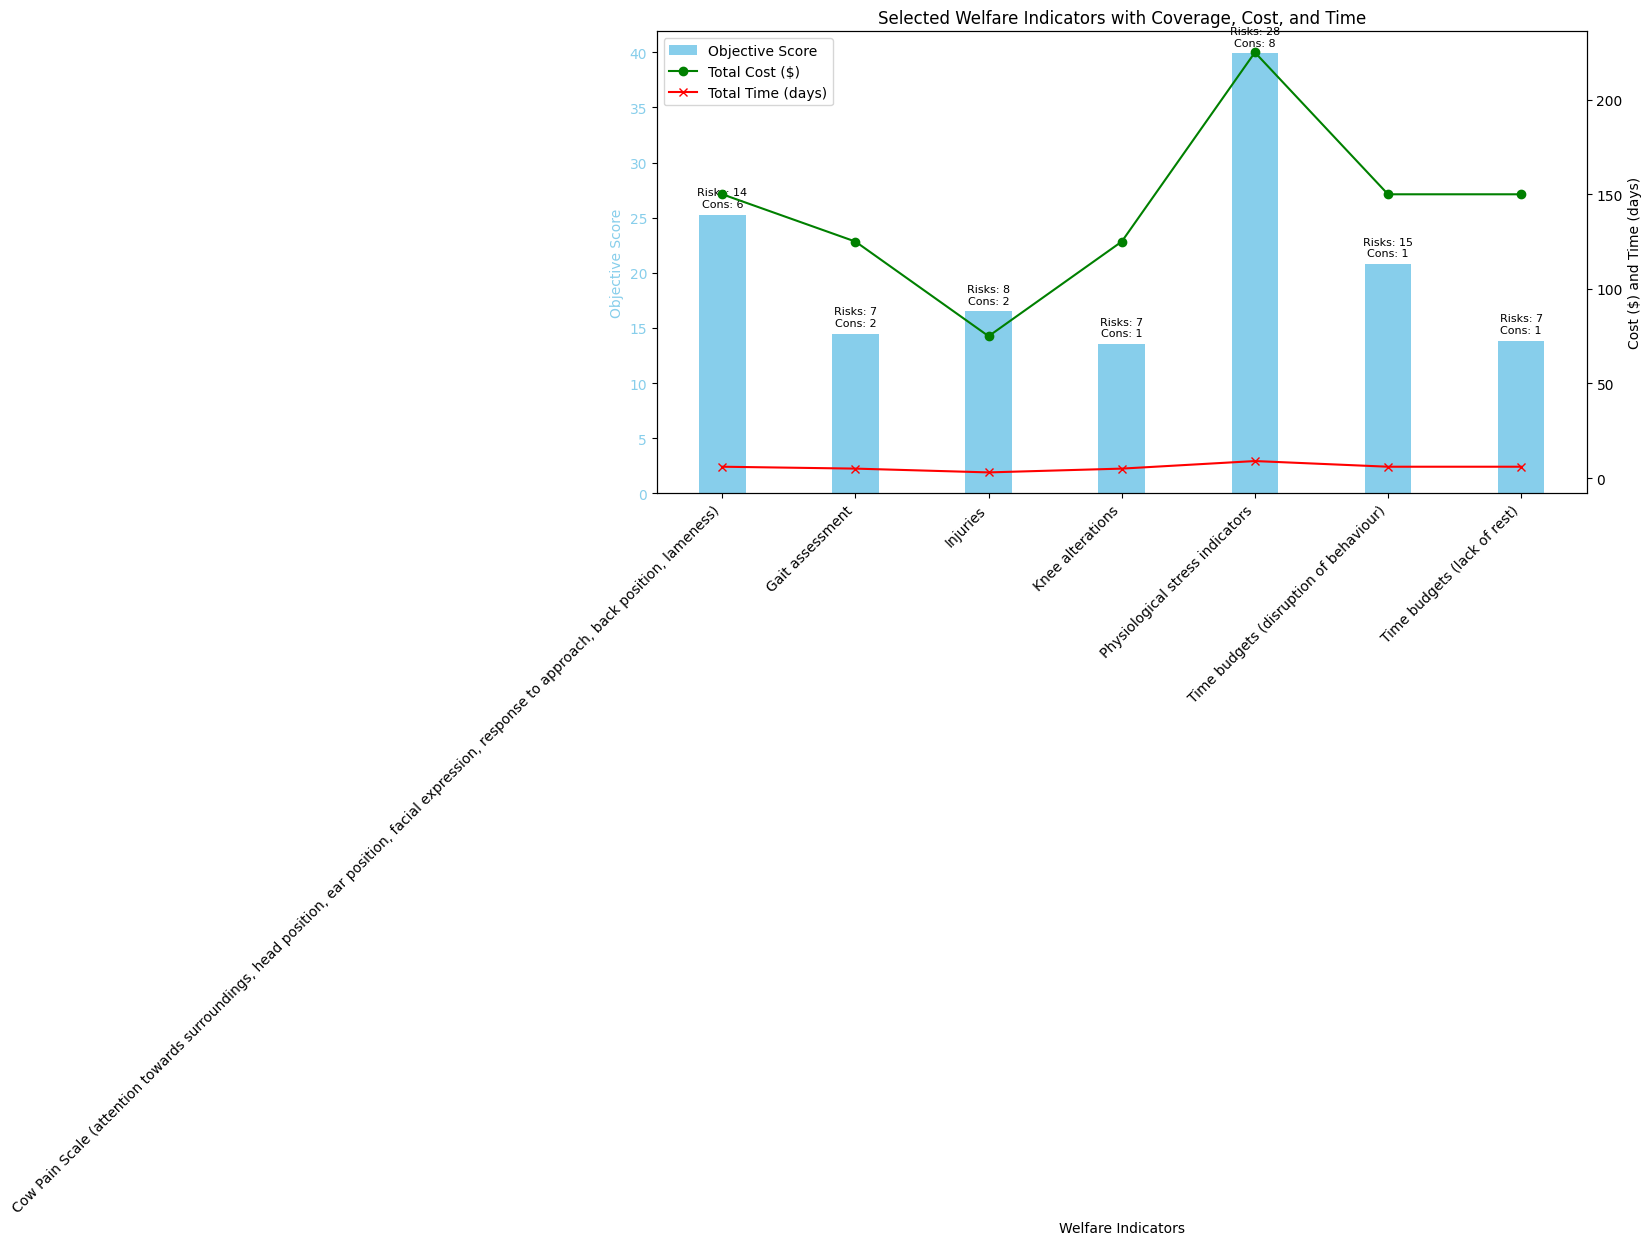

In [76]:
import matplotlib.pyplot as plt

def plot_selected_indicators(selected_df):
    """
    Plot the selected indicators with their Objective Scores, Costs, Times, and Coverage.
    """
    if selected_df.empty:
        print("No indicators selected.")
        return
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Bar plot for Objective Scores
    indicators = selected_df['Welfare_Indicator']
    obj_scores = selected_df['Objective_Score']
    n_risks = selected_df['n_risks']
    n_cons = selected_df['n_cons']
    costs = selected_df['Total_Cost']
    times = selected_df['Total_Time']
    
    bar_width = 0.35
    bars = ax1.bar(indicators, obj_scores, bar_width, label='Objective Score', color='skyblue')
    
    ax1.set_xlabel('Welfare Indicators')
    ax1.set_ylabel('Objective Score', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    plt.xticks(rotation=45, ha='right')
    
    # Twin axis for Cost and Time
    ax2 = ax1.twinx()
    ax2.plot(indicators, costs, label='Total Cost ($)', color='green', marker='o')
    ax2.plot(indicators, times, label='Total Time (days)', color='red', marker='x')
    ax2.set_ylabel('Cost ($) and Time (days)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Adding coverage as annotations
    for idx, row in selected_df.iterrows():
        ax1.text(idx, row['Objective_Score'] + 0.5, f"Risks: {row['n_risks']}\nCons: {row['n_cons']}", 
                 ha='center', va='bottom', fontsize=8)
    
    # Combine legends
    lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    ax1.legend(lines, labels, loc='upper left')
    
    plt.title('Selected Welfare Indicators with Coverage, Cost, and Time')
    plt.tight_layout()
    plt.show()

# Plot the selected indicators
print("Visualization of Selected Indicators:")
plot_selected_indicators(selected_df)


In [77]:
def compute_suffix_scores(items):
    """
    Compute the maximum possible remaining score from each index to the end.
    Useful for branch-and-bound pruning.
    
    Parameters:
    - items: list of tuples (name, multi_obj, n_risks, n_cons, cost, time)
    
    Returns:
    - suffix_scores: list where suffix_scores[i] is the sum of multi_obj from i to end
    """
    n = len(items)
    suffix_scores = [0.0] * (n + 1)
    for i in range(n - 1, -1, -1):
        suffix_scores[i] = suffix_scores[i + 1] + items[i][1]
    return suffix_scores

def backtracking_select_with_bound(
    items, idx,
    budget_left, time_left,
    max_indic_left,
    current_score, current_subset,
    best_solution,
    suffix_scores,
    start_time=None,
    time_limit=None
):
    """
    Recursive backtracking function with branch-and-bound to select indicators.

    Parameters:
    - items: list of tuples (indicator_name, multi_obj, n_risks, n_cons, cost, time)
    - idx: current index in the items list
    - budget_left: remaining budget
    - time_left: remaining time
    - max_indic_left: remaining number of indicators that can be selected
    - current_score: current total objective score
    - current_subset: list of selected indicator indices
    - best_solution: dictionary to store the best solution found so far
    - suffix_scores: precomputed suffix sums of multi_obj
    - start_time: timestamp when the function started (for time limit)
    - time_limit: maximum allowed time in seconds (optional)

    Returns:
    - Updates best_solution in place
    """
    # Check for time limit
    if start_time is not None and time_limit is not None:
        current_time = time.time()
        if (current_time - start_time) > time_limit:
            return

    # Branch-and-Bound Pruning
    if current_score + suffix_scores[idx] <= best_solution['best_score']:
        return

    # Base case: if we've reached the end or no more indicators can be selected
    if idx == len(items) or max_indic_left == 0:
        if current_score > best_solution['best_score']:
            best_solution['best_score'] = current_score
            best_solution['best_subset'] = current_subset.copy()
        return

    # Option 1: Skip the current indicator
    backtracking_select_with_bound(
        items, idx + 1,
        budget_left, time_left,
        max_indic_left,
        current_score, current_subset,
        best_solution,
        suffix_scores,
        start_time,
        time_limit
    )

    # Option 2: Include the current indicator if constraints allow
    name_i, obj_i, n_risks_i, n_cons_i, cost_i, time_i = items[idx]
    if cost_i <= budget_left and time_i <= time_left and max_indic_left > 0:
        current_subset.append(idx)
        backtracking_select_with_bound(
            items, idx + 1,
            budget_left - cost_i,
            time_left - time_i,
            max_indic_left - 1,
            current_score + obj_i,
            current_subset,
            best_solution,
            suffix_scores,
            start_time,
            time_limit
        )
        current_subset.pop()  # Backtrack


def select_best_indicators_bnb(df_agg, budget, deadline, max_indic, time_limit=None, heuristic='score_per_cost'):
    """
    Driver function to select the best subset of indicators using backtracking with branch-and-bound,
    initializing with a greedy solution to ensure minimum performance.
    
    Parameters:
    - df_agg (DataFrame): Aggregated DataFrame with indicators and scores.
    - budget (float): Total budget constraint.
    - deadline (float): Total time constraint.
    - max_indic (int): Maximum number of indicators to select.
    - time_limit (float): Maximum allowed time in seconds (optional).
    - heuristic (str): Heuristic for the greedy selection ('score_per_cost', etc.).
    
    Returns:
    - results_df (DataFrame): DataFrame of selected indicators with coverage details.
    - total_obj (float): Total objective score of the selection.
    - total_cost (float): Total cost of the selection.
    - total_time (float): Total time of the selection.
    - total_risks (int): Total number of unique risks covered.
    - total_cons (int): Total number of unique consequences covered.
    - execution_time (float): Total execution time in seconds.
    """
    # First, run the greedy algorithm to get an initial solution
    greedy_results = select_best_indicators_greedy(
        df_agg,
        budget,
        deadline,
        max_indic,
        heuristic=heuristic
    )
    greedy_df, greedy_obj, greedy_cost, greedy_time, greedy_risks, greedy_cons, greedy_exec_time = greedy_results
    
    # Initialize the best solution with the greedy solution
    best_solution = {
        'best_score': greedy_obj,
        'best_subset': greedy_df['Welfare_Indicator'].tolist()
    }
    
    # Build list with coverage information
    item_list = []
    for _, row in df_agg.iterrows():
        item_list.append((
            row['Welfare_Indicator'],
            row['Multi_Objective'],
            row['n_risks'],
            row['n_cons'],
            row['Total_Cost'],
            row['Total_Time']
        ))
    
    # Compute suffix scores for pruning
    suffix_scores = compute_suffix_scores(item_list)
    
    # Record start time
    start_time = time.time()
    
    # Start recursion with branch-and-bound backtracking
    backtracking_select_with_bound(
        items=item_list,
        idx=0,
        budget_left=budget,
        time_left=deadline,
        max_indic_left=max_indic,
        current_score=0.0,
        current_subset=[],
        best_solution=best_solution,
        suffix_scores=suffix_scores,
        start_time=start_time,
        time_limit=time_limit
    )
    
    # Check if backtracking found a better solution
    if best_solution['best_subset'] != greedy_df['Welfare_Indicator'].tolist():
        # Reconstruct final chosen subset
        chosen_indicators = best_solution['best_subset']
        chosen_df = df_agg[df_agg['Welfare_Indicator'].isin(chosen_indicators)].copy()
        chosen_df = chosen_df[['Welfare_Indicator', 'Multi_Objective', 'n_risks', 'n_cons', 'Total_Cost', 'Total_Time']]
        chosen_df = chosen_df.rename(columns={'Multi_Objective': 'Objective_Score'})
        
        # Calculate totals
        total_obj = sum(chosen_df['Objective_Score'])
        total_cost = sum(chosen_df['Total_Cost'])
        total_time = sum(chosen_df['Total_Time'])
        total_risks = sum(chosen_df['n_risks'])
        total_cons = sum(chosen_df['n_cons'])
    else:
        # If no better solution was found, retain the greedy solution
        chosen_df = greedy_df
        total_obj = greedy_obj
        total_cost = greedy_cost
        total_time = greedy_time
        total_risks = greedy_risks
        total_cons = greedy_cons
    
    # Record end time
    end_time = time.time()
    execution_time = end_time - start_time
    
    return chosen_df, total_obj, total_cost, total_time, total_risks, total_cons, execution_time


In [78]:
selected_df_bnb, best_score_bnb, used_cost_bnb, used_time_bnb, total_risks_bnb, total_cons_bnb, execution_time_bnb = select_best_indicators_bnb(
    df_agg,
    BUDGET,
    DEADLINE,
    MAX_INDICATORS,
    time_limit=TIME_LIMIT,
    heuristic=HEURISTIC
)

# Display the selected indicators
print("Selected Indicators:")
display(selected_df)

# Print summary information
print(f"Best Score Found: {best_score:.2f}")
print(f"Total Cost: ${used_cost:.2f} (Budget = ${BUDGET})")
print(f"Total Time: {used_time:.2f} days (Deadline = {DEADLINE})")
print(f"Total Risks Covered: {total_risks}")
print(f"Total Consequences Covered: {total_cons}")
print(f"Execution Time: {execution_time:.2f} seconds")

Selected Indicators:


,Welfare_Indicator,Objective_Score,n_risks,n_cons,Total_Cost,Total_Time
0,Cow Pain Scale (attention towards surroundings...,25.285714,14,6,150.0,6.0
1,Gait assessment,14.500000,7,2,125.0,5.0
2,Injuries,16.500000,8,2,75.0,3.0
3,Knee alterations,13.571429,7,1,125.0,5.0
4,Physiological stress indicators,39.900000,28,8,225.0,9.0
5,Time budgets (disruption of behaviour),20.800000,15,1,150.0,6.0
6,Time budgets (lack of rest),13.857143,7,1,150.0,6.0


Best Score Found: 144.41
Total Cost: $1000.00 (Budget = $1200)
Total Time: 40.00 days (Deadline = 100)
Total Risks Covered: 86
Total Consequences Covered: 21
Execution Time: 18.17 seconds


In [84]:
# Define your constraints
BUDGET = 1200      # Total budget in dollars
DEADLINE = 100      # Total time in days
MAX_INDICATORS = 6 # Maximum number of indicators to select

TIME_LIMIT = 60    # Maximum allowed time in seconds for backtracking methods

# Define heuristic for greedy selection
HEURISTIC = 'score_per_cost'  # Options: 'score_per_cost', 'score_per_time', 'combined'

# 1. Run Backtracking Selection with Greedy Initialization
selected_df_bt, best_score_bt, used_cost_bt, used_time_bt, total_risks_bt, total_cons_bt, execution_time_bt = select_best_indicators(
    df_agg,
    BUDGET,
    DEADLINE,
    MAX_INDICATORS,
    time_limit=TIME_LIMIT,
    heuristic=HEURISTIC
)


# Display the results
print("Selected Indicators:")
display(selected_df)

print(f"Best Score Found: {best_score:.2f}")
print(f"Total Cost: ${used_cost:.2f} (Budget = ${BUDGET})")
print(f"Total Time: {used_time:.2f} days (Deadline = {DEADLINE})")
print(f"Total Risks Covered: {total_risks}")
print(f"Total Consequences Covered: {total_cons}")
print(f"Execution Time: {execution_time_bt:.2f} seconds")




# 2. Run Branch-and-Bound Selection with Greedy Initialization
selected_df_bnb, best_score_bnb, used_cost_bnb, used_time_bnb, total_risks_bnb, total_cons_bnb, execution_time_bnb = select_best_indicators_bnb(
    df_agg,
    BUDGET,
    DEADLINE,
    MAX_INDICATORS,
    time_limit=TIME_LIMIT,
    heuristic=HEURISTIC
)


# Display the selected indicators
print("Selected Indicators:")
display(selected_df)

# Print summary information
print(f"Best Score Found: {best_score:.2f}")
print(f"Total Cost: ${used_cost:.2f} (Budget = ${BUDGET})")
print(f"Total Time: {used_time:.2f} days (Deadline = {DEADLINE})")
print(f"Total Risks Covered: {total_risks}")
print(f"Total Consequences Covered: {total_cons}")
print(f"Execution Time: {execution_time:.2f} seconds")


# 3. Run Greedy Selection Independently
selected_df_greedy, best_score_greedy, used_cost_greedy, used_time_greedy, total_risks_greedy, total_cons_greedy, execution_time_greedy = select_best_indicators_greedy(
    df_agg,
    BUDGET,
    DEADLINE,
    MAX_INDICATORS,
    heuristic=HEURISTIC
)

# Display the selected indicators
print("Selected Indicators (Greedy):")
display(selected_df_greedy)

# Print summary information
print(f"Best Score Found: {best_score_greedy:.2f}")
print(f"Total Cost: ${used_cost_greedy:.2f} (Budget = ${BUDGET})")
print(f"Total Time: {used_time_greedy:.2f} days (Deadline = {DEADLINE})")
print(f"Total Risks Covered: {total_risks_greedy}")
print(f"Total Consequences Covered: {total_cons_greedy}")
print(f"Execution Time: {execution_time_greedy:.4f} seconds")

Processing index: 0
Selected Indicators:


,Welfare_Indicator,Objective_Score,n_risks,n_cons,Total_Cost,Total_Time
0,Cow Pain Scale (attention towards surroundings...,25.285714,14,6,150.0,6.0
1,Gait assessment,14.500000,7,2,125.0,5.0
2,Injuries,16.500000,8,2,75.0,3.0
3,Knee alterations,13.571429,7,1,125.0,5.0
4,Physiological stress indicators,39.900000,28,8,225.0,9.0
5,Time budgets (disruption of behaviour),20.800000,15,1,150.0,6.0
6,Time budgets (lack of rest),13.857143,7,1,150.0,6.0


Best Score Found: 144.41
Total Cost: $1000.00 (Budget = $1200)
Total Time: 40.00 days (Deadline = 100)
Total Risks Covered: 86
Total Consequences Covered: 21
Execution Time: 17.32 seconds
Selected Indicators:


,Welfare_Indicator,Objective_Score,n_risks,n_cons,Total_Cost,Total_Time
0,Cow Pain Scale (attention towards surroundings...,25.285714,14,6,150.0,6.0
1,Gait assessment,14.500000,7,2,125.0,5.0
2,Injuries,16.500000,8,2,75.0,3.0
3,Knee alterations,13.571429,7,1,125.0,5.0
4,Physiological stress indicators,39.900000,28,8,225.0,9.0
5,Time budgets (disruption of behaviour),20.800000,15,1,150.0,6.0
6,Time budgets (lack of rest),13.857143,7,1,150.0,6.0


Best Score Found: 144.41
Total Cost: $1000.00 (Budget = $1200)
Total Time: 40.00 days (Deadline = 100)
Total Risks Covered: 86
Total Consequences Covered: 21
Execution Time: 17.56 seconds
Selected Indicators (Greedy):


,Welfare_Indicator,Objective_Score,n_risks,n_cons,Total_Cost,Total_Time
9,Calving records (death of cow),11.666667,3,1,75.0,3.0
13,Cow Pain Scale (attention towards surroundings...,25.285714,14,6,150.0,6.0
21,"Hot, red, painful udder",12.400000,5,1,75.0,3.0
27,Injuries,16.500000,8,2,75.0,3.0
29,Lesions of the claw,10.500000,2,2,75.0,3.0
36,Physiological stress indicators,39.900000,28,8,225.0,9.0


Best Score Found: 116.25
Total Cost: $675.00 (Budget = $1200)
Total Time: 27.00 days (Deadline = 100)
Total Risks Covered: 60
Total Consequences Covered: 20
Execution Time: 0.0032 seconds
